# Plain vs. Parallel Deep Decoder

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL
import glob

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
import pickle

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    torch.cuda.set_device(0)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 3


In [2]:
def myimgshow(plt,img,plot_size=(4,4)):
    plt.rcParams["figure.figsize"] = plot_size
    plt.imshow(np.moveaxis(img,0,2))
    #plt.imshow(np.clip(img,0,1),interpolation='nearest')

In [3]:
def load_data(path,data_size=100,post="jpg"):
    # path: directory of images
    # img_name: a specific image
    # black_list: images that are not desired for processing
    images = []
    c = 0
    cn = 0
    for filename in glob.glob(path+"/*"):
        for fn in glob.glob(filename+"/*"):
            if post not in fn:
                continue

            img = Image.open(fn)

            if img.size[0] >= 512 and img.size[1] >= 512: # keep 512*512 images
                cn += 1
                images.append(img)
            img.load()
            c += 1
    print(cn,"3*x*y images chosen out of",c,"images","(x,y>=512 to be cropped as 512*512)")
    
    img_np_list = []
    img_var_list = []
    left, top, right, bottom = 0, 0, 512, 512
    for i,img in enumerate(images):
        img = img.crop((left, top, right, bottom)) 
        img = np.array([pil_to_np(img)])[0]
        img_np_list.append(img / np.max(img))
        img_var_list.append(np_to_var(img_np_list[i]).type(dtype))
    inds = np.random.permutation(len(images))
    np_out = [img_np_list[i] for i in inds[:data_size]]
    var_out = [img_var_list[i] for i in inds[:data_size]]    
    return np_out,var_out

## Load image(s)

In [4]:
path = "./caltech256/caltech256"

In [ ]:
img_np_list,img_var_list = load_data(path,data_size = 100)

In [ ]:
plot_image_grid([np.moveaxis(img,0,2) for img in img_np_list],nrows=5)
plt.show()    

In [ ]:
data_np = img_np_list
data_var = img_var_list

In [ ]:
orig_params = 3*512*512
print("num parameters for each image = 3*512*512 =",orig_params)

## Define network ant train it

### small compression factor

In [25]:
output_depth = [img.shape[0] for img in data_np]
num_channels0 = 139
num_channels = 90
num_layers = 6
decoders_numlayers_list = [2,4,6] # #layers for each decoding block in the parallel architecture
decoders_last_channels = [num_channels]*3
maxv = [np.max(img) for img in data_np]
in_size = [32,32]
out_size = [img[0].shape for img in data_np]

rnd = 500
numit = 20000
rn = 0.001
LR = 0.01

par_psnr = np.zeros(len(data_np))
plain_psnr = np.zeros(len(data_np))

for i,img in enumerate(data_var):
    
    parnet = pardecoder(out_size[i],in_size,num_output_channels = output_depth[i],
                     num_channels=num_channels,
                     decoders_numlayers_list = decoders_numlayers_list,
                     decoders_last_channels = decoders_last_channels).type(dtype)
    
    plainnet = skipdecoder(out_size[i],in_size,output_depth[i],num_layers,num_channels0,skips=False).type(dtype)
    
    bold = '\033[1m'
    end = '\033[0m'
    print(bold + "image {}:".format(i) + end)
    
    print("#parallel_net parameters:",num_param(parnet))
    print("#plain_net parameters:",num_param(plainnet))
    print("train parallel") 
    mse_n, mse_t, parni, parnet = fit( in_size = in_size,
                            num_channels=[num_channels]*(decoders_numlayers_list[-1]-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=LR,
                            img_noisy_var=img,
                            net=parnet,
                            img_clean_var=img,
                            find_best=True,
                            )
    out_img_np = parnet( parni.type(dtype) ).data.cpu().numpy()[0]
    par_psnr[i] = psnr(data_np[i],out_img_np,maxv[i])
    print("\n")
    
    print("train plain")    
    mse_n, mse_t, plainni, plainnet = fit( in_size = in_size,
                            num_channels=[num_channels0]*(num_layers-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=LR,
                            img_noisy_var=img,
                            net=plainnet,
                            img_clean_var=img,
                            find_best=True,
                            #orth_reg=0.1,
                            )    
    out_img_np = plainnet( plainni.type(dtype) ).data.cpu().numpy()[0]
    plain_psnr[i] = psnr(data_np[i],out_img_np,maxv[i])
    print("\n"*2)
    
    with open("./saved_outputs/8_caltech_par_psnr", 'wb') as fn:
        pickle.dump(par_psnr, fn)
    with open("./saved_outputs/8_caltech_plain_psnr", 'wb') as fn:
        pickle.dump(plain_psnr, fn)

print("average parallel_net psnr:",par_psnr.mean())
print("average plain_net psnr:",plain_psnr.mean())

image 0:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000431  Actual loss 0.000431 Actual loss orig 0.000431  Noise Energy 0.000000 

train plain
shape:  [1, 139, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000711  Actual loss 0.000711 Actual loss orig 0.000711  Noise Energy 0.000000 


image 1:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000028  Actual loss 0.000028 Actual loss orig 0.000028  Noise Energy 0.000000 

train plain
shape:  [1, 139, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000052  Actual loss 0.000052 Actual loss orig 0.000052  Noise Energy 0.000000 


image 2:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000241  Actual loss 0.000241 Actual loss orig 0.000241  Noise Energy 0.000000 

train plain
shape:  [1, 139, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000328  Actual loss 0.000328 Actual loss orig 0.000328  Noise Energy 0.000000 


image 11:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000749  Actual loss 0.000749 Actual loss orig 0.000749  Noise Energy 0.000000 

train plain
shape:  [1, 139, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000980  Actual loss 0.000980 Actual loss orig 0.000980  Noise Energy 0.000000   


image 13:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000169  Actual loss 0.000169 Actual loss orig 0.000169  Noise Energy 0.000000 


image 15:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.001228  Actual loss 0.001228 Actual loss orig 0.001228  Noise Energy 0.000000 

train plain
shape:  [1, 139, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.001880  Actual loss 0.001880 Actual loss orig 0.001880  Noise Energy 0.000000 


image 17:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000752  Actual loss 0.000752 Actual loss orig 0.000752  Noise Energy 0.000000 


image 19:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000131  Actual loss 0.000131 Actual loss orig 0.000131  Noise Energy 0.000000 


image 21:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000100  Actual loss 0.000100 Actual loss orig 0.000100  Noise Energy 0.000000 


image 23:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000228  Actual loss 0.000228 Actual loss orig 0.000228  Noise Energy 0.000000 


image 25:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000021  Actual loss 0.000021 Actual loss orig 0.000021  Noise Energy 0.000000 


image 27:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000128  Actual loss 0.000128 Actual loss orig 0.000128  Noise Energy 0.000000 

train plain
shape:  [1, 139, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000121  Actual loss 0.000121 Actual loss orig 0.000121  Noise Energy 0.000000 


image 29:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000099  Actual loss 0.000099 Actual loss orig 0.000099  Noise Energy 0.000000 

train plain
shape:  [1, 139, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000159  Actual loss 0.000159 Actual loss orig 0.000159  Noise Energy 0.000000 


image 30:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000037  Actual loss 0.000037 Actual loss orig 0.000037  Noise Energy 0.000000 

train plain
shape:  [1, 139, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000070  Actual loss 0.000070 Actual loss orig 0.000070  Noise Energy 0.000000    


image 31:
#parallel_net parameters: 99630
#p

Iteration 19990    Train loss 0.000016  Actual loss 0.000016 Actual loss orig 0.000016  Noise Energy 0.000000 


image 48:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000403  Actual loss 0.000403 Actual loss orig 0.000403  Noise Energy 0.000000 

train plain
shape:  [1, 139, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000472  Actual loss 0.000472 Actual loss orig 0.000472  Noise Energy 0.000000 


image 49:
#parallel_net parameters: 99630
#plain_net parameters: 98412
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000043  Actual loss 0.000043 Actual loss orig 0.000043  Noise Energy 0.000000 

train plain
shape:  [1, 139, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000048  Actual loss 0.000048 Actual loss orig 0.000048  Noise Energy 0.000000 


image 50:
#parallel_net parameters: 99630
#plai

KeyboardInterrupt: 

In [29]:
### load saved results
with open("./saved_outputs/8_caltech_par_psnr", 'rb') as f:
    par_psnr = pickle.load(f)
with open("./saved_outputs/8_caltech_plain_psnr", 'rb') as f:
    plain_psnr = pickle.load(f)

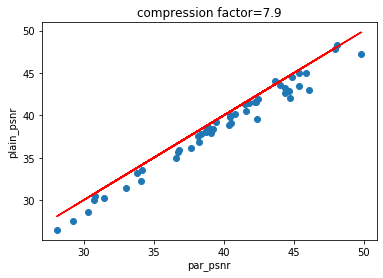

In [30]:
plt.scatter(par_psnr,plain_psnr)
plt.title("compression factor={}".format(round(orig_params/num_param(parnet),1)))
plt.xlabel("par_psnr")
plt.ylabel("plain_psnr")
plt.plot(par_psnr,par_psnr,"r")
plt.show()

### large compression factor

In [34]:
output_depth = [img.shape[0] for img in data_np]
num_channels0 = 68
num_channels = 44
num_layers = 6
decoders_numlayers_list = [2,4,6] # #layers for each decoding block in the parallel architecture
decoders_last_channels = [num_channels]*3
maxv = [np.max(img) for img in data_np]
in_size = [32,32]
out_size = [img[0].shape for img in data_np]

rnd = 500
numit = 20000
rn = 0.001
LR = 0.01

par_psnr = np.zeros(len(data_np))
plain_psnr = np.zeros(len(data_np))

for i,img in enumerate(data_var):
    
    parnet = pardecoder(out_size[i],in_size,num_output_channels = output_depth[i],
                     num_channels=num_channels,
                     decoders_numlayers_list = decoders_numlayers_list,
                     decoders_last_channels = decoders_last_channels).type(dtype)
    
    plainnet = skipdecoder(out_size[i],in_size,output_depth[i],num_layers,num_channels0,skips=False).type(dtype)
    
    bold = '\033[1m'
    end = '\033[0m'
    print(bold + "image {}:".format(i) + end)
    
    print("#parallel_net parameters:",num_param(parnet))
    print("#plain_net parameters:",num_param(plainnet))
    print("train parallel") 
    mse_n, mse_t, parni, parnet = fit( in_size = in_size,
                            num_channels=[num_channels]*(decoders_numlayers_list[-1]-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=LR,
                            img_noisy_var=img,
                            net=parnet,
                            img_clean_var=img,
                            find_best=True,
                            )
    out_img_np = parnet( parni.type(dtype) ).data.cpu().numpy()[0]
    par_psnr[i] = psnr(data_np[i],out_img_np,maxv[i])
    print("\n")
    
    print("train plain")    
    mse_n, mse_t, plainni, plainnet = fit( in_size = in_size,
                            num_channels=[num_channels0]*(num_layers-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=LR,
                            img_noisy_var=img,
                            net=plainnet,
                            img_clean_var=img,
                            find_best=True,
                            #orth_reg=0.1,
                            )    
    out_img_np = plainnet( plainni.type(dtype) ).data.cpu().numpy()[0]
    plain_psnr[i] = psnr(data_np[i],out_img_np,maxv[i])
    print("\n"*2)
    
    with open("./saved_outputs/32_caltech_par_psnr", 'wb') as fn:
        pickle.dump(par_psnr, fn)
    with open("./saved_outputs/32_caltech_plain_psnr", 'wb') as fn:
        pickle.dump(plain_psnr, fn)

print("average parallel_net psnr:",par_psnr.mean())
print("average plain_net psnr:",plain_psnr.mean())

image 0:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.002091  Actual loss 0.002091 Actual loss orig 0.002091  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.002262  Actual loss 0.002262 Actual loss orig 0.002262  Noise Energy 0.000000 


image 1:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000211  Actual loss 0.000211 Actual loss orig 0.000211  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000267  Actual loss 0.000267 Actual loss orig 0.000267  Noise Energy 0.000000 


image 2:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000025  Actual loss 0.000025 Actual loss orig 0.000025  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000049  Actual loss 0.000049 Actual loss orig 0.000049  Noise Energy 0.000000 


image 10:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000142  Actual loss 0.000142 Actual loss orig 0.000142  Noise Energy 0.000000 


image 12:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.002475  Actual loss 0.002475 Actual loss orig 0.002475  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000590  Actual loss 0.000590 Actual loss orig 0.000590  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000674  Actual loss 0.000674 Actual loss orig 0.000674  Noise Energy 0.000000  


image 15:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000184  Actual loss 0.000184 Actual loss orig 0.000184  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000510  Actual loss 0.000510 Actual loss orig 0.000510  Noise Energy 0.000000 


image 18:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000550  Actual loss 0.000550 Actual loss orig 0.000550  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000457  Actual loss 0.000457 Actual loss orig 0.000457  Noise Energy 0.000000 


image 21:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000327  Actual loss 0.000327 Actual loss orig 0.000327  Noise Energy 0.000000 


image 23:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000771  Actual loss 0.000771 Actual loss orig 0.000771  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.001055  Actual loss 0.001055 Actual loss orig 0.001055  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000942  Actual loss 0.000942 Actual loss orig 0.000942  Noise Energy 0.000000 


image 26:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000434  Actual loss 0.000434 Actual loss orig 0.000434  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000328  Actual loss 0.000328 Actual loss orig 0.000328  Noise Energy 0.000000 


image 29:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000778  Actual loss 0.000778 Actual loss orig 0.000778  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000784  Actual loss 0.000784 Actual loss orig 0.000784  Noise Energy 0.000000 


image 32:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.006500  Actual loss 0.006500 Actual loss orig 0.006500  Noise Energy 0.000000 


image 34:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000424  Actual loss 0.000424 Actual loss orig 0.000424  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.001059  Actual loss 0.001059 Actual loss orig 0.001059  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.001016  Actual loss 0.001016 Actual loss orig 0.001016  Noise Energy 0.000000 


image 37:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000279  Actual loss 0.000279 Actual loss orig 0.000279  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000224  Actual loss 0.000224 Actual loss orig 0.000224  Noise Energy 0.000000 


image 40:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.003427  Actual loss 0.003427 Actual loss orig 0.003427  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.003365  Actual loss 0.003365 Actual loss orig 0.003365  Noise Energy 0.000000 


image 43:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.001905  Actual loss 0.001905 Actual loss orig 0.001905  Noise Energy 0.000000 


image 45:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000111  Actual loss 0.000111 Actual loss orig 0.000111  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 19990    Train loss 0.000077  Actual loss 0.000077 Actual loss orig 0.000077  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000042  Actual loss 0.000042 Actual loss orig 0.000042  Noise Energy 0.000000 


image 48:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.002184  Actual loss 0.002184 Actual loss orig 0.002184  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.002065  Actual loss 0.002065 Actual loss orig 0.002065  Noise Energy 0.000000 


image 49:
#parallel_net parameters: 24420
#plain_net parameters: 24004
train parallel
shape:  [1, 44, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000068  Actual loss 0.000068 Actual loss orig 0.000068  Noise Energy 0.000000 

train plain
shape:  [1, 68, 32, 32]
optimize with 

KeyboardInterrupt: 

In [35]:
### load saved results
with open("./saved_outputs/32_caltech_par_psnr", 'rb') as f:
    par_psnr = pickle.load(f)
with open("./saved_outputs/32_caltech_plain_psnr", 'rb') as f:
    plain_psnr = pickle.load(f)

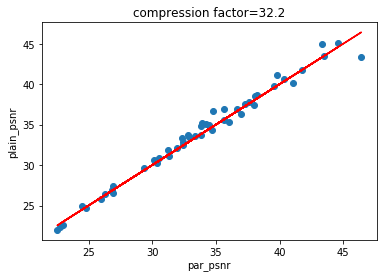

In [37]:
plt.scatter(par_psnr,plain_psnr)
plt.title("compression factor={}".format(round(orig_params/num_param(parnet),1)))
plt.xlabel("par_psnr")
plt.ylabel("plain_psnr")
plt.plot(par_psnr,par_psnr,"r")
plt.show()